<a href="https://colab.research.google.com/github/BojanMakivic/Predicting-fitness-level-of-cancer-survivors/blob/master/Regression_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TF, sklearn continuous model

# Mount the google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Python ≥3.5 
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd

# Figures plot
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# GUI to import data file (xlsx)

In [3]:
from google.colab import files
import io
#uploaded = files.upload() 
#df = pd.read_excel(io.BytesIO(uploaded['Data.xlsx']))

df = pd.read_excel('/content/drive/MyDrive/Data.xlsx')
df = pd.DataFrame(df)

In [4]:
df.info() # BW nad BH are standing for body weight and body height, respectively

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1712 entries, 0 to 1711
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Age     1712 non-null   int64  
 1   Sex     1712 non-null   object 
 2   BW      1712 non-null   float64
 3   BH      1712 non-null   int64  
 4   Wmax    1712 non-null   int64  
 5   Norm    1712 non-null   float64
 6   Level   1712 non-null   object 
 7   Type    1712 non-null   object 
dtypes: float64(2), int64(3), object(3)
memory usage: 107.1+ KB


Good        973
Moderate    622
Bad         117
Name: Level, dtype: int64

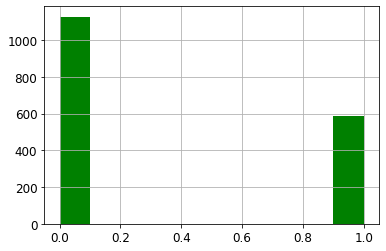

In [5]:
# Histogram of gender distribution
df['Sex']=np.where(df['Sex']=="W",0,1)
df['Sex'].hist(label=int,align='mid',color=['green'])
df['Level'].value_counts()

## Writing a function for BMI calculation and adding a new column
https://en.wikipedia.org/wiki/Body_mass_index

In [6]:
# Function
def bmi(bw,bh):
    return bw/((bh/100)*(bh/100))

In [7]:
# Adding a new column
df['BMI']=bmi(df.iloc[:,2],df.iloc[:,3]) 

In [8]:
#df.loc[df['Sex'] == 'W'].describe()
df.describe()

,Age,Sex,BW,BH,Wmax,Norm,BMI
count,1712.000000,1712.000000,1712.000000,1712.000000,1712.000000,1712.000000,1712.000000
mean,55.765771,0.341706,75.929030,168.342874,118.494743,85.097715,26.726015
std,10.930445,0.474420,16.636734,8.964106,41.874907,23.719701,5.137146
min,18.000000,0.000000,38.000000,136.000000,26.000000,19.620253,15.570934
25%,49.000000,0.000000,63.000000,162.000000,88.000000,68.965517,23.183603
50%,56.000000,0.000000,73.500000,168.000000,112.000000,84.274745,25.884072
75%,62.000000,1.000000,86.000000,174.000000,141.000000,100.934829,29.666548
max,88.000000,1.000000,143.000000,200.000000,327.000000,175.652174,49.480969


## Histogram distribution of each attribute

In [9]:
np.random.seed(42) # To ensure the repeatability of train/test results. It means that every time we run models the train/test samples will be same
del df['Norm']
del df['Type']
del df['Level']
#del df['Sex']
#del df['BW']
#del df['BMI']
#del df['Wmax'] # continuous

In [10]:
#df=df.loc[df['Type'] == 'Brustkrebs']
#df=df.loc[df['Gender'] == 'W']
#df

# PREPARING TRAINING AND TEST SET

In [11]:
## CONTINUOUS

from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)
train_labels = train_set["Wmax"].copy()       # Save a copy of label variable
train_set = train_set.drop("Wmax", axis=1)    # Drop label variable from training set
test_lebels = test_set["Wmax"].copy()
test_set = test_set.drop("Wmax", axis=1) 

In [12]:
train_num = train_set

In [13]:
test_num = test_set
#test_num

# PIPELINE

In [ ]:
# Pipline to scale numerical variables and transform categorical variable (gender) into binary

# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import PowerTransformer

# pipeline = Pipeline([
#         ('std_scaler', PowerTransformer(method="yeo-johnson")),])
# train_prepared = pipeline.fit_transform(train_num[['Age','BH','BW','BMI']])

In [14]:
# Pipline to scale numerical variables and transform categorical variable (gender) into binary

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

pipeline = Pipeline([
        ('std_scaler', MinMaxScaler()),])
train_prepared = pipeline.fit_transform(train_num)

In [ ]:
#train_prepared # Only numerical variables were scaled (Age, BW, BH and BMI)

In [ ]:
# from sklearn.preprocessing import QuantileTransformer
# from sklearn.preprocessing import PowerTransformer
# bc = PowerTransformer(method="box-cox")
# yj = PowerTransformer(method="yeo-johnson")
# qt = QuantileTransformer()

# X_trans_qt = yj.fit(train_num).transform(test_set)
# X_trans_qt

In [15]:
test_prepared = pipeline.fit_transform(test_num)

In [ ]:
# from scipy import stats
# k2, p = stats.normaltest(test_prepared[:,4])
# alpha = 0.05
# print("p = {:g}".format(p))
# if p < alpha:  # null hypothesis: x comes from a normal distribution
#   print("The null hypothesis can be rejected")
# else:
#   print("The null hypothesis cannot be rejected")

In [ ]:
# from scipy.stats import shapiro
# stat, p = shapiro(train_prepared[:,4])
# print('Statistics=%.3f, p=%.3f' % (stat, p))
# # interpret
# alpha = 0.05
# if p > alpha:
# 	print('Sample looks Gaussian (fail to reject H0)')
# else:
# 	print('Sample does not look Gaussian (reject H0)')

In [ ]:
# from statsmodels.graphics.gofplots import qqplot
# from matplotlib import pyplot
# # q-q plot
# qqplot(train_prepared[:,4], line='s')
# pyplot.show()

In [ ]:
#from sklearn.preprocessing import OneHotEncoder
#from sklearn.compose import ColumnTransformer

#num_attribs = list(train_num) #train_num
#cat_attribs = ["Sex"]

#full_pipeline = ColumnTransformer([
        #("num", pipeline, num_attribs),
        #("cat", OneHotEncoder(), cat_attribs),])

#train_prepared = full_pipeline.fit_transform(train_set) # Training set is ready for use

In [ ]:
#train_prepared # Numerical and categorical variables are scaled

In [ ]:
# test_prepared = full_pipeline.fit_transform(test_set)
# test_prepared

## Shapiro-Wilk-Test (scaled data)

In [ ]:
df2 = pd.DataFrame(train_prepared, columns=['Age','Sex','BW','BH','BMI'])
df2['Sex']=np.where(df2['Sex']==0,'Female','Male')
#df2

In [ ]:
df3 = pd.DataFrame(train_prepared, columns=['Age','Sex','BW','BH','BMI'])
from scipy import stats
for ind,i in enumerate(df3.columns):
  print(df3.columns[ind], stats.shapiro(df3[i]))

Age (0.9907028079032898, 1.2803398874439154e-07)
Sex (0.5988175868988037, 0.0)
BW (0.9618477821350098, 1.754958795301692e-18)
BH (0.9887033700942993, 8.420094843586412e-09)
BMI (0.9598639011383057, 5.684283839839368e-19)


Data was not normaly distributed

## Probability density function (scaled data)

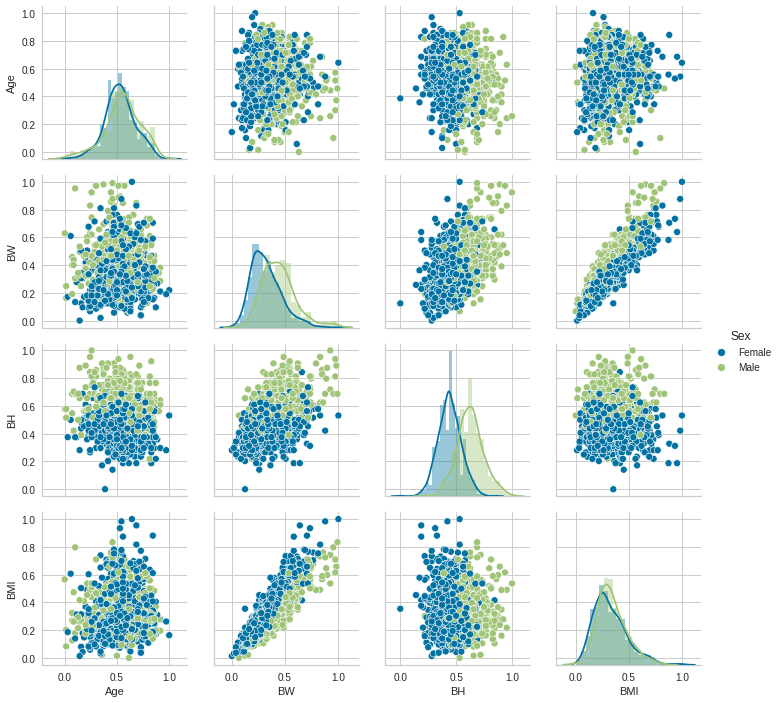

In [ ]:
import seaborn as sns

g = sns.PairGrid(df2, hue='Sex', hue_kws={"markers": ["o", "s"]})
g.map_diag(sns.distplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

# SELECTING AND TRAINING THE MODEL

## Linear regression

In [16]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression(n_jobs=1)
lin_reg_fit = lin_reg.fit(train_prepared, train_labels)

In [17]:
# RMSE for linear model
from sklearn.metrics import mean_squared_error

watt_predictions = lin_reg.predict(train_prepared)
lin_mse = mean_squared_error(train_labels, watt_predictions)
lin_rmse = np.sqrt(lin_mse)
print("RMSE is: ",lin_rmse) # We can see that the prediction error for linear model is 32.5 Watt 

RMSE is:  32.46354580734144


In [18]:
errors = abs(watt_predictions - train_labels)# Print out the mean absolute error (mae)

print('Mean Absolute Error:', round(np.mean(errors), 2), 'Watt.')

Mean Absolute Error: 25.07 Watt.


In [19]:
watt_predictions_test = lin_reg.predict(test_prepared)

In [20]:
from sklearn.metrics import r2_score
r2_score(watt_predictions_test, test_lebels)

-0.470028952808748

In [21]:
lin_reg.score(train_prepared, train_labels)

0.40059638323238256

In [22]:
# Calculate mean absolute percentage error (MAPE)
mape = 100/len(train_labels) * sum(errors / train_labels)# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 75.17 %.


## Residuals plot

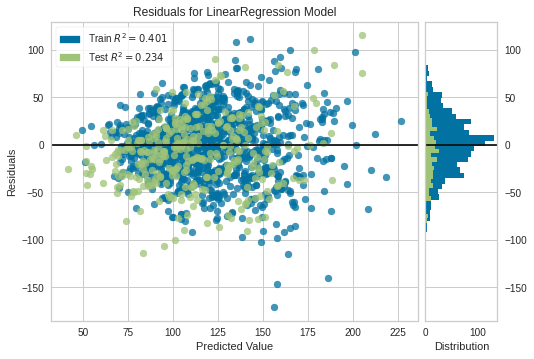

In [23]:
from yellowbrick.regressor import residuals_plot
viz = residuals_plot(lin_reg, train_prepared, train_labels, test_prepared, test_lebels)

### Fine-tune linear regression

In [24]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

param_grid = [
    
    {'copy_X': [True],
     'fit_intercept': [True],
     'n_jobs': [1,], 
     'normalize': [False]
  }]

model = LinearRegression()
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search_lr = GridSearchCV(model, param_grid, cv=10,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search_lr.fit(train_prepared, train_labels)

GridSearchCV(cv=10, estimator=LinearRegression(),
             param_grid=[{'copy_X': [True], 'fit_intercept': [True],
                          'n_jobs': [1], 'normalize': [False]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [25]:
grid_search_lr.best_params_

{'copy_X': True, 'fit_intercept': True, 'n_jobs': 1, 'normalize': False}

In [26]:
grid_search_lr.best_estimator_

LinearRegression(n_jobs=1, normalize=False)

In [27]:
negative_mse = grid_search_lr.best_score_
rmse = np.sqrt(-negative_mse)
rmse

32.65822845474984

In [28]:
feature_names = list(train_set.columns)
feature_names

['Age', 'Sex', 'BW', 'BH', 'BMI']

In [29]:
from sklearn.inspection import permutation_importance
r = permutation_importance(lin_reg_fit, test_prepared, test_lebels, n_repeats=10, random_state=42, n_jobs=2)
for i in r.importances_mean.argsort()[::-1]:
  if r.importances_mean[i] - 2 * r.importances_std[i] > -1:
    print(f"{feature_names[i]:<8}"
          f"{r.importances_mean[i]:.3f}"
          f" +/- {r.importances_std[i]:.3f}")

BW      0.521 +/- 0.044
BMI     0.154 +/- 0.027
Age     0.137 +/- 0.051
Sex     0.088 +/- 0.018
BH      0.018 +/- 0.013


## Support vector regressor (SVR)

In [30]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="rbf", epsilon=3, C=100, cache_size= 100, degree=0.1, gamma='scale', max_iter = -1, tol =1, coef0= 0.1)
svm_reg_fit = svm_reg.fit(train_prepared, train_labels)

In [31]:
# RMSE for SVR model
from sklearn.metrics import mean_squared_error

watt_SVR_predictions = svm_reg.predict(train_prepared)
SVR_mse = mean_squared_error(train_labels, watt_SVR_predictions)
SVR_rmse = np.sqrt(SVR_mse)
print ("RMSE is: ",SVR_rmse) # We can see that the prediction error for SVR model is 32.6 Wat

RMSE is:  31.082506998716934


In [32]:
errors = abs(watt_SVR_predictions - train_labels)# Print out the mean absolute error (mae)

print('Mean Absolute Error:', round(np.mean(errors), 2), 'Watt.')

Mean Absolute Error: 23.57 Watt.


In [33]:
from sklearn.metrics import r2_score
watt_predictions_test = svm_reg.predict(test_prepared)
r2_score(watt_predictions_test, test_lebels)

-0.412291138318597

In [34]:
svm_reg.score(train_prepared, train_labels)

0.450510330303335

In [35]:
# Calculate mean absolute percentage error (MAPE)
mape = 100/len(train_labels) * sum(errors / train_labels)# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 76.84 %.


## Residuals plot

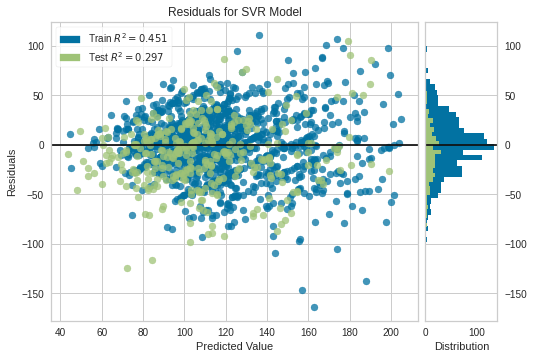

In [36]:
from yellowbrick.regressor import residuals_plot
viz = residuals_plot(svm_reg, train_prepared, train_labels, test_prepared, test_lebels)

### Fine-tune SVR

In [37]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

param_grid = [
    
    {'C': [100],
     'cache_size': [100],
     'coef0': [0.1],
     'degree': [0.1],
     'epsilon': [3],
     'gamma': ['scale'],
     'kernel': ['rbf'],
     'max_iter': [-1],
     'shrinking': [True],
     'tol': [1]
  }]

svm_reg = SVR()
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search_svr = GridSearchCV(svm_reg, param_grid, cv=10,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search_svr.fit(train_prepared, train_labels)

GridSearchCV(cv=10, estimator=SVR(),
             param_grid=[{'C': [100], 'cache_size': [100], 'coef0': [0.1],
                          'degree': [0.1], 'epsilon': [3], 'gamma': ['scale'],
                          'kernel': ['rbf'], 'max_iter': [-1],
                          'shrinking': [True], 'tol': [1]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [38]:
grid_search_svr.best_params_

{'C': 100,
 'cache_size': 100,
 'coef0': 0.1,
 'degree': 0.1,
 'epsilon': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 1}

In [39]:
negative_mse = grid_search_svr.best_score_
rmse = np.sqrt(-negative_mse)
rmse

31.906525329779708

In [40]:
from sklearn.inspection import permutation_importance
r = permutation_importance(svm_reg_fit, test_prepared, test_lebels, n_repeats=10, random_state=42, n_jobs=2)
for i in r.importances_mean.argsort()[::-1]:
  if r.importances_mean[i] - 2 * r.importances_std[i] > -1:
    print(f"{feature_names[i]:<8}"
          f"{r.importances_mean[i]:.3f}"
          f" +/- {r.importances_std[i]:.3f}")

BH      0.216 +/- 0.024
Sex     0.203 +/- 0.025
Age     0.157 +/- 0.050
BW      0.096 +/- 0.024
BMI     0.022 +/- 0.020


## Random forest model

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42, oob_score=True, n_estimators=2000, max_features=2, bootstrap = True, max_depth = 8, min_samples_leaf = 4, min_samples_split = 2)
forest_fit = forest_reg.fit(train_prepared, train_labels)

In [ ]:
# RMSE for random forest model

watt_RF_predictions = forest_reg.predict(train_prepared)
forest_mse = mean_squared_error(train_labels, watt_RF_predictions)
forest_rmse = np.sqrt(forest_mse)
print("RMSE is: ", forest_rmse) # We can see that the prediction error for linear model is 13.1 Wat (until now the model with lowest prediction error)

RMSE is:  27.03238583052479


In [ ]:
errors = abs(watt_RF_predictions - train_labels)# Print out the mean absolute error (mae)

print('Mean Absolute Error:', round(np.mean(errors), 2), 'Watt.')

Mean Absolute Error: 20.94 Watt.


In [ ]:
forest_reg.score(train_prepared, train_labels)

0.584380221213958

In [ ]:
# Calculate mean absolute percentage error (MAPE)
mape = 100/len(train_labels) * sum(errors / train_labels)# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 79.28 %.


In [ ]:
np.mean(mape)

20.72292913389906

## Residuals plot

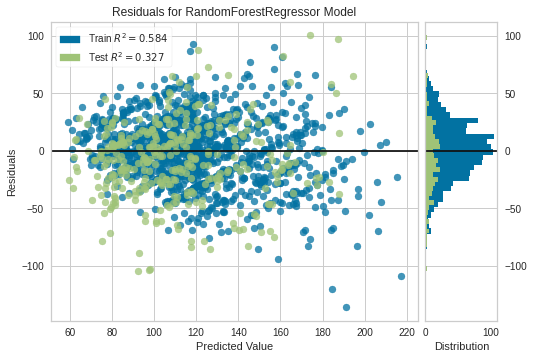

In [ ]:
from yellowbrick.regressor import residuals_plot
viz = residuals_plot(forest_reg, train_prepared, train_labels, test_prepared, test_lebels)

### Fine-tune RF

In [ ]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

param_grid = [
    {'bootstrap': [True],
     'n_estimators': [2000], 
     'max_features': [2],
     'max_depth': [8],
     'min_samples_leaf': [4],
     'min_samples_split': [2]
  }]

forest_reg = RandomForestRegressor(random_state=42)

grid_search_rf = GridSearchCV(forest_reg, param_grid, cv=10,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search_rf.fit(train_prepared, train_labels)

GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'bootstrap': [True], 'max_depth': [8],
                          'max_features': [2], 'min_samples_leaf': [4],
                          'min_samples_split': [2], 'n_estimators': [2000]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [ ]:
grid_search_rf.best_params_

{'bootstrap': True,
 'max_depth': 8,
 'max_features': 2,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 2000}

In [ ]:
grid_search_rf.best_estimator_

RandomForestRegressor(max_depth=8, max_features=2, min_samples_leaf=4,
                      n_estimators=2000, random_state=42)

In [ ]:
negative_mse = grid_search_rf.best_score_
rmse = np.sqrt(-negative_mse)
rmse

32.152181875421

In [ ]:
from sklearn.inspection import permutation_importance
r = permutation_importance(forest_fit, test_prepared, test_lebels, n_repeats=10, random_state=42, n_jobs=2)
for i in r.importances_mean.argsort()[::-1]:
  if r.importances_mean[i] - 2 * r.importances_std[i] > -1:
    print(f"{feature_names[i]:<8}"
          f"{r.importances_mean[i]:.3f}"
          f" +/- {r.importances_std[i]:.3f}")

BH      0.212 +/- 0.025
Age     0.125 +/- 0.038
Sex     0.111 +/- 0.020
BW      0.101 +/- 0.027
BMI     0.024 +/- 0.011


# CROSS-VALIDATION OF MODELS (Training set)

'''The following code randomly splits the training set into 10 distinct subsets called folds, then it trains and evaluates the model 10 times,
picking a different fold for evaluation every time and training on the other 9 folds. The result is an array containing the 10 evaluation scores:'''

In [ ]:
# Function to display the score statistics

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [ ]:
from sklearn.model_selection import cross_val_score

## Linear model

In [ ]:
lin_scores = cross_val_score(lin_reg, train_prepared, train_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [30.53455934 27.46985412 38.43562164 32.76486023 38.07501257 31.38868645
 31.97227142 31.11989247 32.31836557 30.94683766]
Mean: 32.50259614886735
Standard deviation: 3.1845139953005894


## SVR

In [ ]:
SVR_scores = cross_val_score(svm_reg, train_prepared, train_labels,
                                scoring="neg_mean_squared_error", cv=10)
SVR_rmse_scores = np.sqrt(-SVR_scores)
display_scores(SVR_rmse_scores)

Scores: [33.08946124 28.69160442 42.30383222 34.62286763 39.95543067 32.13769339
 33.53230583 33.11922414 32.18442602 31.23494387]
Mean: 34.08717894367206
Standard deviation: 3.8619350721229115


## Random forest

In [ ]:
forest_scores = cross_val_score(grid_search_rf, train_prepared, train_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [30.55063131 27.63770315 38.58241094 31.8558116  36.00211489 30.81268093
 32.04384016 31.26287157 30.90550911 30.53113512]
Mean: 32.01847087691286
Standard deviation: 2.929218676445058


In [ ]:
# Return the table of cross-validation for all three models

scores = cross_val_score(grid_search_lr,  train_prepared, train_labels, scoring="neg_mean_squared_error", cv=10)
scores_rf = cross_val_score(grid_search_rf,  train_prepared, train_labels, scoring="neg_mean_squared_error", cv=10)
scores_svr = cross_val_score(grid_search_svr,  train_prepared, train_labels, scoring="neg_mean_squared_error", cv=10)
a = pd.Series(np.sqrt(-scores)).describe()
b = pd.Series(np.sqrt(-scores_svr)).describe()
c = pd.Series(np.sqrt(-scores_rf)).describe()

scores_df = pd.DataFrame({
    "lin_reg": a,
    "SVR":b,
    "forest_reg": c
    })
scores_df

,lin_reg,SVR,forest_reg
count,10.000000,10.000000,10.000000
mean,32.502596,31.771915,32.018471
std,3.356772,3.086134,3.087668
min,27.469854,27.831435,27.637703
25%,30.990101,30.180058,30.616144
50%,31.680479,31.184903,31.084190
75%,32.653237,32.081332,31.996833
max,38.435622,37.791989,38.582411


# FEATURE IMPORTANCE

### Random forest

In [ ]:
feature_importances = grid_search_rf.best_estimator_.feature_importances_
feature_importances

array([0.2729123 , 0.14629095, 0.1485376 , 0.32483092, 0.10742823])

In [ ]:
feature_names = list(test_num.columns)
feature_names

['Age', 'Sex', 'BW', 'BH', 'BMI']

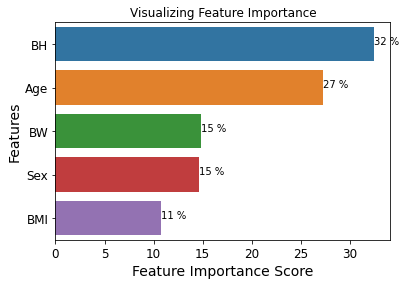

In [ ]:
import seaborn as sns

feature_imp = pd.Series(feature_importances,index=feature_names).sort_values(ascending=False)
sns.barplot(x=feature_imp*100, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Feature Importance")
for index, value in enumerate(feature_imp*100):
    plt.text(value, index, str("{:.0f}".format(value)+" %")) # Rounding the float
plt.show()

# TESTING THE MODEL

In [45]:
final_model = grid_search_svr

X_test = test_set
y_test = test_lebels

X_test_prepared = pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [46]:
final_rmse

34.87029197439935

In [47]:
from sklearn import metrics
from sklearn.metrics import r2_score

y_oob = final_model.predict(X_test_prepared)
print("R2",r2_score(y_test, y_oob)) # Amount of the variation in the response variable which is predictable from the input independent variable
print("R2",final_model)

R2 0.29697634945978024
R2 GridSearchCV(cv=10, estimator=SVR(),
             param_grid=[{'C': [100], 'cache_size': [100], 'coef0': [0.1],
                          'degree': [0.1], 'epsilon': [3], 'gamma': ['scale'],
                          'kernel': ['rbf'], 'max_iter': [-1],
                          'shrinking': [True], 'tol': [1]}],
             return_train_score=True, scoring='neg_mean_squared_error')


In [44]:
from scipy import stats
# 95% confidence interval for the test RMSE
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([33.24605796, 39.31191953])

In [ ]:
errors = abs(final_predictions - y_test)# Print out the mean absolute error (mae)

print('Mean Absolute Error:', round(np.mean(errors), 2), 'Watt.')

Mean Absolute Error: 28.17 Watt.


In [ ]:
# Calculate mean absolute percentage error (MAPE)
mape = 100/len(y_test) * sum(errors / y_test)# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(mape, 2), '%.')

Accuracy: 26.07 %.


# PREDICTING Wmax

In [ ]:
import warnings
warnings.filterwarnings("ignore")

age = input("Please enter the AGE: ")
age = int(age)
print("Age is: ", age)

bmi = input ("Please ebter the BMI: ")
bmi = int(bmi)
print("BMI is: ", bmi)

bh = input("Please enter the BODY HEIGHT: ")
bh = int(bh)
print("Body height is: ", bh)

bw = input("Please enter the BODY WEIGHT: ")
bw = int(bw)
print("Body weight is: ", bw)

g = input("Please enter your gender(W for women or M for man): ").upper()
print("Gender is: ", g)

a = pd.DataFrame({'Age':[age],'BMI':[bmi],'Gender':[g],'BH':[bh],'BW':[bw]})
b = full_pipeline.transform(a)
print("Your predicted Wmax is: ",int(final_model.predict(b)))

Please enter the AGE: 40
Age is:  40
Please ebter the BMI: 27
BMI is:  27
Please enter the BODY HEIGHT: 180
Body height is:  180
Please enter the BODY WEIGHT: 87
Body weight is:  87
Please enter your gender(W for women or M for man): M
Gender is:  M
Your predicted Wmax is:  183
